In [12]:
# Utilities
import sys
import os
import fastai
import torch
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from collections import defaultdict
import imageio
%matplotlib inline

# Machine Learning
import torch
import torchvision
# from torchvision import transforms
# import pytorch_lightning as pl
from torch import optim
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from fastai.callbacks.hooks import num_features_model
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm


# Add root of project to PYTHON_PATH so we can import correctly
if os.path.abspath('../../') not in {os.path.abspath(path) for path in sys.path}:
    sys.path.insert(0, os.path.abspath('../../'))

# Import SSIC common stuffs
from ssic.ssic import SSIC
from ssic.util import set_random_seed

# if you dont have a .env file set it here
os.environ.setdefault('DATASET_DIR', '~/downloads/datasets/ssic')
os.environ.setdefault('STORAGE_DIR', '../out')

# Initialise SSIC paths, data and other stuffs, searches for a .env file in the project with these variables specified, also checkpoints os.environ and sys.path
SSIC.init()

# SSIC.init is required to locate these imports
from ranger import Ranger
from radam import RAdam
from lookahead import Lookahead
from Mish.Torch.functional import mish
from Mish.Torch.mish import Mish

SSIC.get_train_imagelist(0.2)

%matplotlib inline
# import matplotlib.pyplot as plt
# from fastai.vision import *
# from fastai.metrics import accuracy
# from fastai.basic_data import *
# from skimage.util import montage
# import pandas as pd
# from torch import optim
# import re
# import json
# import cv2
# # import albumentations
# from fastai.callbacks.hooks import num_features_model
# from torch.nn import L1Loss

# import numpy as np
# import torch
# import pandas as pd
# import random
# import string

[RESTORED]: os.environ
[LOADED]: 
[RESTORED]: sys.path
[STORAGE_DIR]: /home/nmichlo/workspace/snake-id-old/notebooks/out
[DATASET_DIR]: /home/nmichlo/downloads/datasets/ssic
[DATASET_CLASS_CSV]: /home/nmichlo/downloads/datasets/ssic/class_idx_mapping.csv
[DATASET_TRAIN_DIR]: /home/nmichlo/downloads/datasets/ssic/train
[DATASET_TEST_DIR]: /home/nmichlo/downloads/datasets/ssic/round1


In [13]:
# model = EfficientNet.from_pretrained(model_name)
# model = torchvision.models.alexnet(pretrained=True)
# model = torchvision.models.googlenet(pretrained=True)
# model = EfficientNet.from_pretrained('efficientnet-b0')
model = torch.hub.load('pytorch/vision:v0.4.2', 'mobilenet_v2', pretrained=True)

set_random_seed(42)

# load dataset
src = SSIC.get_train_imagelist(0.2)
# src = (ImageList.from_folder(path='../../data/train/').split_by_rand_pct(0.2).label_from_folder())

data = src.transform(
    tfms=([rotate(degrees=(-90,90), p=1)],[]),
    size=224, # image_size # EfficientNet.get_image_size(model_name)
    resize_method=ResizeMethod.SQUISH
).databunch(bs=64).normalize(imagenet_stats)

Using cache found in /home/nmichlo/.cache/torch/hub/pytorch_vision_v0.4.2


[SEEDED]: 42


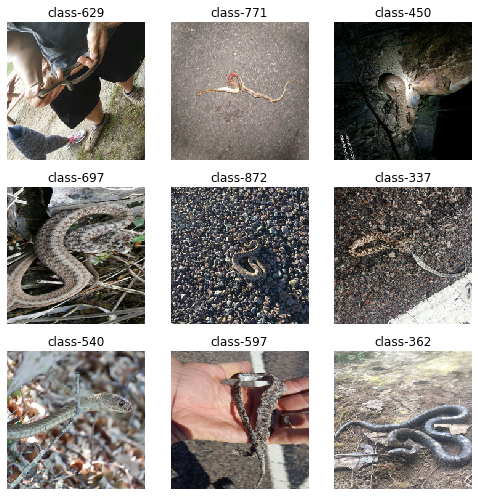

In [8]:
data.show_batch(3,figsize=(7,7))

In [9]:
list(children(model))[-2:]

# add extra layer to EfficientNet
model.add_module('_fc',nn.Linear(1280, data.c))

# loss
loss_func = LabelSmoothingCrossEntropy()

# optimiser
# optim = partial(torch.optim.RMSprop)
# optim = partial(RAdam)
opt_func = partial(Ranger) # Lookahead + RAdam
lr=1e-3

kappa = KappaScore()
kappa.weights = 'quadratic'

# CREATE LEARNER
learn = Learner(
    data,
    model,
    loss_func=loss_func,
    opt_func=opt_func,
    metrics=[
        accuracy,
        FBeta(beta=1, average='micro'),
        top_k_accuracy,
        kappa,
        Recall(average='micro'),
        Precision(average='micro')
        # explained_variance,
    ]
)

In [11]:
# what is this...?
# _ = learn.split([[learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:8]],
#              [learn.model._blocks[8:],learn.model._conv_head], 
#              [learn.model._bn1,learn.model._fc]])


In [ ]:
epochs = 40
save_name = f'mobilenet-v2-for-{epochs}'


learn.fit(epochs, lr=lr)
# learn.fit_one_cycle(40,max_lr=slice(lr/100,lr)) # not for Ranger or RAdam

learn.save(save_name, return_path=True)

epoch,train_loss,valid_loss,accuracy,f_beta,top_k_accuracy,kappa_score,recall,precision,time
0,2.739295,2.638142,0.495541,0.000000,0.821513,0.484530,nan,nan,06:55
1,2.487737,2.438145,0.549718,0.000000,0.856458,0.539023,nan,nan,06:58
2,2.391901,2.337790,0.578414,0.000000,0.866772,0.566031,nan,nan,06:55
3,2.336960,2.331382,0.578232,0.000000,0.868107,0.565573,nan,nan,06:58
4,2.249409,2.271197,0.596554,0.000000,0.878420,0.584994,nan,nan,06:57
5,2.224161,2.242063,0.604623,0.000000,0.882000,0.585371,nan,nan,06:55
6,2.188427,2.220075,0.611418,0.000000,0.883516,0.596839,nan,nan,06:57
7,2.153142,2.185640,0.620579,0.000000,0.889098,0.611051,nan,nan,06:56
8,2.185241,2.198794,0.618637,0.000000,0.886974,0.605423,nan,nan,06:56
9,2.092478,2.172747,0.621913,0.000000,0.890979,0.596384,nan,nan,06:56


In [ ]:
# learn.save(save_name, return_path=True)
# learn = learn.load(save_name)

In [10]:
learn = learn.load('mobilenet-v2-for-40')

set state called


In [11]:
learn.fit(epochs, lr=1e-15)

epoch,train_loss,valid_loss,accuracy,f_beta,top_k_accuracy,kappa_score,recall,precision,time
0,1.482402,2.171132,0.664563,0.000000,0.895650,0.643124,nan,nan,15:03
1,1.474699,2.163386,0.665413,0.000000,0.896621,0.642524,nan,nan,07:41


KeyboardInterrupt: 